**Set environemnt**

In [1]:
import sys
sys.path.append('../')
from config_sing import *

You are on Duke Server: Singularity: Proj CombEffect
BASE DIRECTORY:     /mount/work
PATH OF SOURCE:     /mount/work/source
PATH OF EXECUTABLE: /mount/work/exe
PATH OF ANNOTATION: /mount/work/annotation
PATH OF PROJECT:    /mount/project
PATH OF RESULTS:    /mount/work/out/proj_combeffect



In [2]:
import sqlite3
import itertools as it
from collections import defaultdict
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("seaborn-whitegrid")

import math
import random
from sklearn.manifold import TSNE
from functools import reduce

### Set Samples
fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT    = reduce(fun, ["Input", idx])
INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])
SAMPLES  = np.concatenate([INPUT20X, TFX_DMSO, TFX_DEX])

### file path of database
fdiry = os.path.join(FD_RES, 'database')
fname = "fragment.db"
FPATH_DB = os.path.join(fdiry, fname)

## Helper function

In [3]:
### https://stackoverflow.com/questions/12581437/python-random-sample-with-a-generator-iterable-iterator
def iter_sample_fast(iterable, samplesize):
    
    ### init
    results = []
    iterator = iter(iterable)
    
    ### Fill in the first samplesize elements:
    try:
        for _ in range(samplesize):
            results.append(next(iterator))
    except StopIteration:
        ### return everything if samplesize > len(iterable)
        random.shuffle(results)
        return results
    
    ### continue iterating through the elements and update the list
    random.shuffle(results)  # Randomize their positions
    for i, v in enumerate(iterator, samplesize):
        r = random.randint(0, i)
        if r < samplesize:
            results[r] = v  # at a decreasing rate, replace random items
    return results

In [4]:
def get_frag(sample, fpath_db=FPATH_DB):
    ### set query
    query_out = f"""
        SELECT Cnt.fragment, Cnt.count, Cnt.sample
        FROM   Count Cnt
        WHERE  Cnt.sample = '{sample}'
        """
    
    ### query out fragments from the sample
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query)
        for row in rows:
            yield row

def get_pct(frags, fpath_db=FPATH_DB):
    """..."""
    ###
    txt = ', '.join('?' for _ in frags)
    query_out = f"""
        SELECT   Frg.fragment, Frg.pct_gc
        FROM     Fragment Frg
        WHERE    Frg.fragment IN ({txt})
        ORDER BY Frg.fragment
        """
    
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query, frags)
    return rows

def get_depth(frag):
    """..."""
    ###
    chrom, start, end = frag.split("_")
    mid = math.ceil((int(start) + int(end)) / 2)
    query_out = f"""
        SELECT Cov.sample, Cov.depth, Sam.treatment, Sam.size
        FROM   Coverage Cov
        JOIN   Sample Sam ON Cov.sample = Sam.sample
        WHERE  Cov.location = {mid};
        """
    ###
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        cursor.execute(query)
        rows   = cursor.fetchall()
    
    ###
    cnames = ["Sample", "Depth", "Trt", "Size"]
    dat = pd.DataFrame(rows, columns=cnames)
    dat = dat.assign(LogNorm_Depth=lambda x: np.log1p(x.Depth) - np.log(x.Size))
    res1 = pd.Series(dat["LogNorm_Depth"].values, index=dat["Sample"])
    
    ###
    dat = dat.groupby("Trt")["LogNorm_Depth"].mean()
    dat["TFX_DMSO_vs_Inp20x"] = dat["TFX_DMSO"] - dat["Input_20x"]
    dat["TFX_Dex_vs_Inp20x"]  = dat["TFX_Dex"]  - dat["Input_20x"]
    dat["TFX_Dex_vs_DMSO"]    = dat["TFX_Dex"]  - dat["TFX_DMSO"]
    res2 = dat
    
    return pd.concat([res1, res2], axis=0)

def get_annot(frag, fpath_db=FPATH_DB, verbose=False):
    ### set query
    query_out = f"""
        SELECT Mtf.motif, Mtf.score
        FROM Annotation Ant
        JOIN Motif      Mtf ON Ant.binding = Mtf.binding
        WHERE Ant.fragment = '{frag}'
        """
    
    ### query out motif bindings on the fragment
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query)
        
    ### summarize the motif scores
    dct = defaultdict(lambda: 0)
    for idx, row in enumerate(rows):
        ### parse info
        motif, score = row

        ### sum the scores with same motifs
        dct[motif] += score
        
    if verbose:
        print(f"Fragment: {frg}; # Bindings: {idx+1}; # Motifs: {len(dct)}")
            
    return dct

## Check fragment database

In [5]:
query_out = """
    SELECT name 
    FROM sqlite_master 
    WHERE type = 'index';
    """
###
fpath_db = FPATH_DB
with sqlite3.connect(fpath_db) as conn:
    query  = query_out
    cursor = conn.cursor()
    cursor = cursor.execute(query)
    rows   = cursor.fetchall()
    rows = np.r_[rows].ravel()

for row in np.sort(rows):
    print(row)

idx_annot_frag
idx_location
idx_motif_loc
sqlite_autoindex_Annotation_1
sqlite_autoindex_Fragment_1
sqlite_autoindex_Motif_1
sqlite_autoindex_Sample_1


## Get fragments from PER1 region

In [6]:
%%time
random.seed(123)
N   = 500

lst_frg = list()
for sam in SAMPLES:
    print(sam)
    
    ### random select fragments
    gen = get_frag(sam)
    lst = iter_sample_fast(gen, N)
    lst = np.sort(lst, axis=0)
    lst_frg.append(lst)

Input1_20x
Input2_20x
Input3_20x
Input4_20x
Input5_20x
TFX2_DMSO
TFX3_DMSO
TFX4_DMSO
TFX5_DMSO
TFX2_Dex
TFX3_Dex
TFX4_Dex
TFX5_Dex
CPU times: user 105 ms, sys: 10.6 ms, total: 116 ms
Wall time: 167 ms


In [7]:
dat = pd.DataFrame(np.concatenate(lst_frg), columns=["Fragment", "Count", "Sample"])
dat[['Chrom', 'Start', 'End']] = dat['Fragment'].str.split('_', expand=True)

dat = dat.astype({"Start": int, "End": int, "Count": int})
dat = dat.assign(Mid = lambda x: np.ceil((x.Start + x.End) / 2))
dat = dat.assign(Len = lambda x: x.End - x.Start)
dat = dat.astype({"Mid": int})

dat = dat.set_index("Fragment")
dat_frg = dat
dat_frg

,Count,Sample,Chrom,Start,End,Mid,Len
Fragment,,,,,,,
chr17_8148005_8149015,1,Input1_20x,chr17,8148005,8149015,8148510,1010
chr17_8148017_8148955,1,Input1_20x,chr17,8148017,8148955,8148486,938
chr17_8148092_8149102,1,Input1_20x,chr17,8148092,8149102,8148597,1010
chr17_8148098_8149186,1,Input1_20x,chr17,8148098,8149186,8148642,1088
chr17_8148122_8149107,1,Input1_20x,chr17,8148122,8149107,8148615,985
...,...,...,...,...,...,...,...
chr17_8158169_8159111,6,TFX5_Dex,chr17,8158169,8159111,8158640,942
chr17_8158170_8159111,7,TFX5_Dex,chr17,8158170,8159111,8158641,941
chr17_8158177_8159105,8,TFX5_Dex,chr17,8158177,8159105,8158641,928


In [8]:
frags = dat.index.to_numpy()
frags = np.unique(frags)
frags.shape

(5422,)

## Get GC content

In [9]:
%%time
gen = get_pct(frags)
dat_pct = pd.DataFrame(gen, columns = ["Fragment", "Pct_GC"])
dat_pct = dat_pct.set_index("Fragment")
dat_pct

CPU times: user 22.3 ms, sys: 3.37 ms, total: 25.6 ms
Wall time: 26.3 ms


,Pct_GC
Fragment,
chr17_8148000_8148888,0.582207
chr17_8148001_8148888,0.581736
chr17_8148002_8149023,0.587659
chr17_8148002_8149046,0.580460
chr17_8148002_8149066,0.583647
...,...
chr17_8159539_8160538,0.515516
chr17_8159543_8160508,0.518135
chr17_8159608_8160580,0.512346


## Get coverage

In [10]:
%%time
dct = dict()
for frg in frags:
    dct[frg] = get_depth(frg)
    
dat_cov_full = pd.DataFrame.from_dict(dct, orient="index")
dat_cov_full.index.name = 'Fragment'
dat_cov_full

CPU times: user 39.2 s, sys: 2.38 s, total: 41.6 s
Wall time: 44.2 s


,Input1,Input2,Input3,Input4,Input5,Input1_20x,Input2_20x,Input3_20x,Input4_20x,Input5_20x,...,TFX3_Dex,TFX4_Dex,TFX5_Dex,Input,Input_20x,TFX_DMSO,TFX_Dex,TFX_DMSO_vs_Inp20x,TFX_Dex_vs_Inp20x,TFX_Dex_vs_DMSO
Fragment,,,,,,,,,,,,,,,,,,,,,
chr17_8148000_8148888,-13.851876,-14.873694,-14.129934,-13.815718,-13.980048,-13.747196,-13.876706,-13.859296,-13.940291,-13.930689,...,-15.009458,-14.651027,-14.034179,-14.130254,-13.870836,-13.520507,-14.368960,0.350328,-0.498124,-0.848452
chr17_8148001_8148888,-13.851876,-14.873694,-14.129934,-13.815718,-13.980048,-13.767501,-13.876706,-13.859296,-13.940291,-13.930689,...,-15.009458,-14.651027,-14.034179,-14.130254,-13.874897,-13.529711,-14.368960,0.345186,-0.494063,-0.839249
chr17_8148002_8149023,-13.909035,-14.873694,-14.190559,-14.121099,-13.980048,-13.907647,-13.926873,-13.924034,-14.026058,-13.977836,...,-14.691005,-14.314555,-14.094804,-14.214887,-13.952490,-13.554379,-14.308794,0.398111,-0.356305,-0.754415
chr17_8148002_8149046,-13.909035,-14.740162,-14.190559,-14.052107,-14.060090,-13.893006,-13.946354,-13.927224,-14.014188,-13.991725,...,-14.691005,-14.314555,-14.094804,-14.190391,-13.954499,-13.546916,-14.308794,0.407584,-0.354295,-0.761879
chr17_8148002_8149066,-13.909035,-14.740162,-14.190559,-14.052107,-14.060090,-13.887209,-13.993342,-13.936854,-14.017142,-14.009362,...,-14.691005,-14.468706,-14.064032,-14.190391,-13.968782,-13.581856,-14.339639,0.386926,-0.370857,-0.757783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr17_8159539_8160538,-14.950489,-14.873694,-14.478241,-14.814247,-15.158703,-14.736435,-14.814635,-14.717600,-14.934914,-14.885543,...,-15.297141,-15.413168,-15.768780,-14.855075,-14.817825,-15.967295,-15.625243,-1.149470,-0.807417,0.342052
chr17_8159543_8160508,-14.950489,-14.873694,-14.478241,-14.814247,-15.158703,-14.671052,-14.791468,-14.717600,-14.912935,-14.860225,...,-15.297141,-15.413168,-15.768780,-14.855075,-14.790656,-15.967295,-15.625243,-1.176639,-0.834587,0.342052
chr17_8159608_8160580,-14.950489,-14.873694,-14.565252,-14.814247,-15.158703,-14.813667,-14.921734,-14.869406,-15.061065,-15.003326,...,-15.297141,-15.413168,-15.768780,-14.872477,-14.933839,-15.967295,-15.625243,-1.033456,-0.691403,0.342052


In [11]:
dat_cov = dat_cov_full.loc[:,["Input_20x", "TFX_DMSO_vs_Inp20x", "TFX_Dex_vs_Inp20x"]]

## Get Annotation

In [12]:
%%time
dct = dict()
for frg in frags:
    dct[frg] = get_annot(frg)
    
dat_ant = pd.DataFrame.from_dict(dct, orient="index").fillna(0)
dat_ant = dat_ant.add_prefix("Mtf_")
dat_ant.index.name = 'Fragment'
dat_ant

CPU times: user 5.26 s, sys: 1.78 s, total: 7.04 s
Wall time: 15.7 s


,Mtf_GLIS,Mtf_GC-tract,Mtf_ZNF680,Mtf_GCM,Mtf_NR/19,Mtf_ZNF143,Mtf_ZFN121,Mtf_PLAG1,Mtf_CTCF,Mtf_NR/16,...,Mtf_DDIT3+CEBPA,Mtf_IRF/4,Mtf_OVOL1,Mtf_NR/2,Mtf_ZNF232,Mtf_HLTF,Mtf_HD/25,Mtf_AIRE,Mtf_SOX/5,Mtf_HD/7
Fragment,,,,,,,,,,,,,,,,,,,,,
chr17_8148000_8148888,23.1883,91.402615,15.3419,7.5087,23.5700,38.43685,4.9710,11.3956,24.1703,44.586567,...,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0
chr17_8148001_8148888,23.1883,91.402615,15.3419,7.5087,23.5700,38.43685,4.9710,11.3956,24.1703,44.586567,...,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0
chr17_8148002_8149023,23.1883,114.212037,15.3419,7.5087,23.5700,54.69065,19.0648,11.3956,33.3872,55.261133,...,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0
chr17_8148002_8149046,23.1883,114.212037,15.3419,7.5087,23.5700,54.69065,19.0648,11.3956,33.3872,55.261133,...,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0
chr17_8148002_8149066,23.1883,114.212037,15.3419,7.5087,23.5700,54.69065,19.0648,11.3956,33.3872,55.261133,...,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr17_8158030_8158903,0.0000,60.505500,0.0000,8.2338,24.1669,23.45560,37.0032,7.0908,17.9474,33.968700,...,0.0,0.0,0.0,10.3433,3.1837,0.0,0.0,0.0,0.0,0.0
chr17_8158031_8158902,0.0000,60.505500,0.0000,8.2338,24.1669,23.45560,37.0032,7.0908,17.9474,33.968700,...,0.0,0.0,0.0,10.3433,3.1837,0.0,0.0,0.0,0.0,0.0
chr17_8158031_8158903,0.0000,60.505500,0.0000,8.2338,24.1669,23.45560,37.0032,7.0908,17.9474,33.968700,...,0.0,0.0,0.0,10.3433,3.1837,0.0,0.0,0.0,0.0,0.0


## Merge all information

In [13]:
dat = dat_frg.join(dat_pct).join(dat_cov).join(dat_ant)
dat = dat.reset_index()

dat["Sample"] = pd.Categorical(dat["Sample"], SAMPLES)
dat = dat.sort_values(["Sample", "Fragment"])
dat

,Fragment,Count,Sample,Chrom,Start,End,Mid,Len,Pct_GC,Input_20x,...,Mtf_DDIT3+CEBPA,Mtf_IRF/4,Mtf_OVOL1,Mtf_NR/2,Mtf_ZNF232,Mtf_HLTF,Mtf_HD/25,Mtf_AIRE,Mtf_SOX/5,Mtf_HD/7
11,chr17_8148005_8149015,1,Input1_20x,chr17,8148005,8149015,8148510,1010,0.588119,-13.949942,...,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
19,chr17_8148017_8148955,1,Input1_20x,chr17,8148017,8148955,8148486,938,0.587420,-13.935106,...,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
45,chr17_8148092_8149102,1,Input1_20x,chr17,8148092,8149102,8148597,1010,0.575248,-14.016676,...,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
46,chr17_8148098_8149186,1,Input1_20x,chr17,8148098,8149186,8148642,1088,0.577206,-13.968814,...,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
57,chr17_8148122_8149107,1,Input1_20x,chr17,8148122,8149107,8148615,985,0.571574,-14.015898,...,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6262,chr17_8158169_8159111,6,TFX5_Dex,chr17,8158169,8159111,8158640,942,0.519108,-14.315992,...,0.0,0.0,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000
6266,chr17_8158170_8159111,7,TFX5_Dex,chr17,8158170,8159111,8158641,941,0.519660,-14.315992,...,0.0,0.0,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000
6270,chr17_8158177_8159105,8,TFX5_Dex,chr17,8158177,8159105,8158641,928,0.524785,-14.315992,...,0.0,0.0,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000
6284,chr17_8158224_8159128,8,TFX5_Dex,chr17,8158224,8159128,8158676,904,0.521018,-14.310120,...,0.0,0.0,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000


## t-SNE

In [14]:
%%time
lst = [col for col in dat.columns if col.startswith('Mtf')]
X   = dat[lst].to_numpy()
X = TSNE(n_components=2, init='pca', random_state=123).fit_transform(X)

dat = dat.assign(tsne_x = X[:,0], tsne_y = X[:,1])
dat

CPU times: user 1min 17s, sys: 388 ms, total: 1min 17s
Wall time: 44.9 s


,Fragment,Count,Sample,Chrom,Start,End,Mid,Len,Pct_GC,Input_20x,...,Mtf_OVOL1,Mtf_NR/2,Mtf_ZNF232,Mtf_HLTF,Mtf_HD/25,Mtf_AIRE,Mtf_SOX/5,Mtf_HD/7,tsne_x,tsne_y
11,chr17_8148005_8149015,1,Input1_20x,chr17,8148005,8149015,8148510,1010,0.588119,-13.949942,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.001437,-0.469894
19,chr17_8148017_8148955,1,Input1_20x,chr17,8148017,8148955,8148486,938,0.587420,-13.935106,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-2.077733,0.436163
45,chr17_8148092_8149102,1,Input1_20x,chr17,8148092,8149102,8148597,1010,0.575248,-14.016676,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.997205,-4.805748
46,chr17_8148098_8149186,1,Input1_20x,chr17,8148098,8149186,8148642,1088,0.577206,-13.968814,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.703322,-5.546436
57,chr17_8148122_8149107,1,Input1_20x,chr17,8148122,8149107,8148615,985,0.571574,-14.015898,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-2.277785,-5.049574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6262,chr17_8158169_8159111,6,TFX5_Dex,chr17,8158169,8159111,8158640,942,0.519108,-14.315992,...,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000,-99.556831,-54.618870
6266,chr17_8158170_8159111,7,TFX5_Dex,chr17,8158170,8159111,8158641,941,0.519660,-14.315992,...,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000,-99.556831,-54.618870
6270,chr17_8158177_8159105,8,TFX5_Dex,chr17,8158177,8159105,8158641,928,0.524785,-14.315992,...,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000,-99.593430,-53.596203
6284,chr17_8158224_8159128,8,TFX5_Dex,chr17,8158224,8159128,8158676,904,0.521018,-14.310120,...,0.0,10.3433,3.1837,5.9501,7.3717,0.0000,0.0000,0.0000,-99.892532,-57.102734


In [15]:
print(dat_frg.shape)
print(dat_pct.shape)
print(dat_ant.shape)
print(dat.shape)

(6494, 7)
(5422, 1)
(5422, 240)
(6494, 254)


## Store the matrix

In [16]:
fdiry = os.path.join(FD_RES, 'database')
fname = "fragment_annot_map_per1.csv"
fpath = os.path.join(fdiry, fname)

dat.to_csv(fpath, index=False)

## Plot

In [15]:
def set_colorbar(fig, ax, im):
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

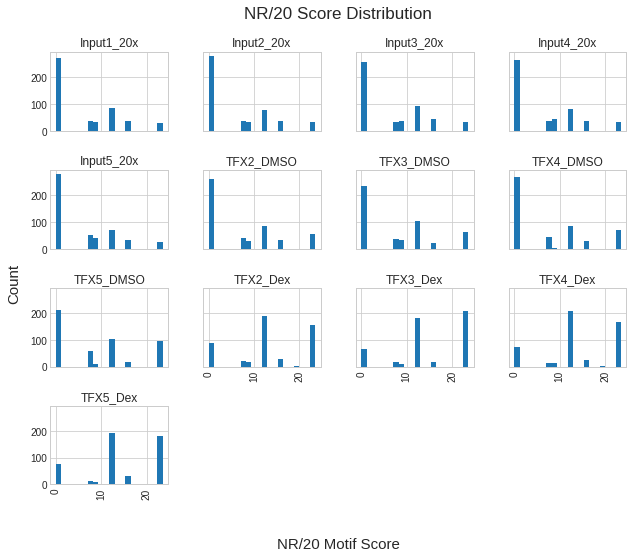

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
axes = dat.loc[:,"Mtf_NR/20"].hist(
    ax=ax,
    bins=20, 
    by=dat.loc[:,"Sample"], 
    #density=True, 
    sharex=True,
    sharey=True)

#axes = np.ravel(axes)
#for ax in axes:
#    ax.set_yscale('log')
    
fig.suptitle("NR/20 Score Distribution", fontsize=17)
fig.text(0.5, 0.04, 'NR/20 Motif Score', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize=15)
plt.show()

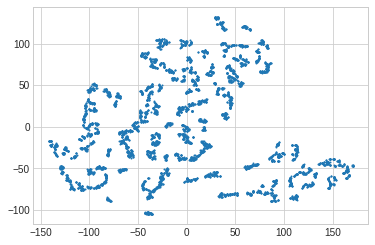

In [75]:
plt.scatter(dat["tsne_x"], dat["tsne_y"], s=1)

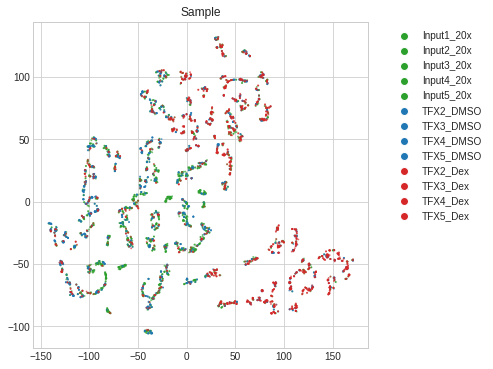

In [41]:
###
### Ref: stackoverflow: plot-different-color-for-different-categorical-levels-using-matplotlib 

### set color mapping
#colors = list(sns.color_palette("Greens", 5)) + list(sns.color_palette("Blues", 4)) + list(sns.color_palette("Reds", 4))
colors = ["tab:green"] * 5 + ["tab:blue"] * 4 + ["tab:red"] * 4
colors = {k:v for k, v in zip(SAMPLES, colors)}

### scatter plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=dat.loc[:,"Sample"].map(colors), alpha=0.5)


### add a legend
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) 
    for k, v in colors.items()
]
ax.legend(title='', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("Sample")
plt.show()

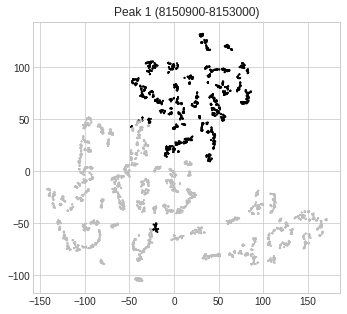

In [38]:
cval = dat.loc[:,"Mid"].to_numpy()
cval = (8150900 < cval) & (cval < 8153000)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
cmap = mpl.colors.ListedColormap(['#bdbdbd', '#000000'])
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap=cmap)
#set_colorbar(fig, ax, img)
ax.set_title("Peak 1 (8150900-8153000)")
plt.show()

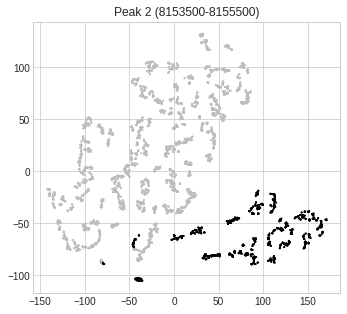

In [39]:
cval = dat.loc[:,"Mid"].to_numpy()
cval = (8153500 < cval) & (cval < 8155500)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
cmap = mpl.colors.ListedColormap(['#bdbdbd', '#000000'])
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap=cmap)
#set_colorbar(fig, ax, img)
ax.set_title("Peak 2 (8153500-8155500)")
plt.show()

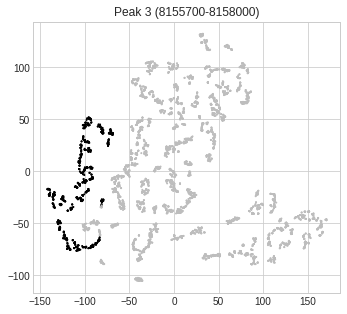

In [40]:
cval = dat.loc[:,"Mid"].to_numpy()
cval = (8155700 < cval) & (cval < 8158000)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
cmap = mpl.colors.ListedColormap(['#bdbdbd', '#000000'])
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap=cmap)
#set_colorbar(fig, ax, img)
ax.set_title("Peak 3 (8155700-8158000)")
plt.show()

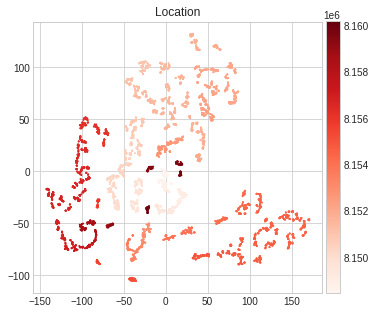

In [20]:
cval = dat.loc[:,"Mid"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("Location")
plt.show()

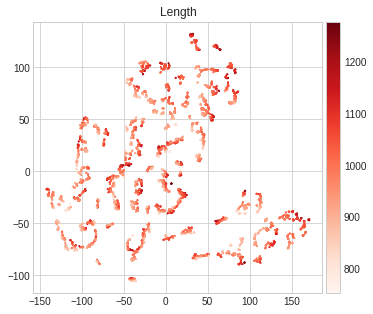

In [21]:
cval = dat.loc[:,"Len"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("Length")
plt.show()

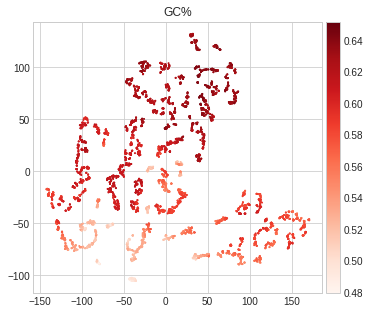

In [22]:
cval = dat.loc[:,"Pct_GC"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("GC%")
plt.show()

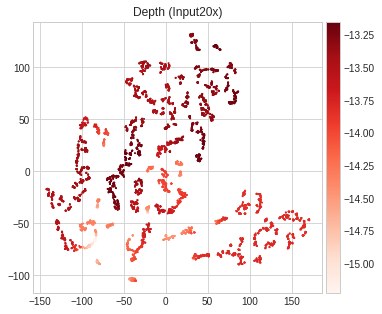

In [23]:
cval = dat.loc[:,"Input_20x"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("Depth (Input20x)")
plt.show()

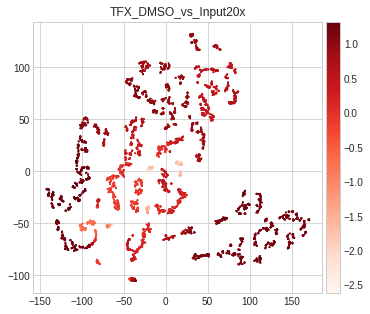

In [24]:
cval = dat.loc[:,"TFX_DMSO_vs_Inp20x"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("TFX_DMSO_vs_Input20x")
plt.show()

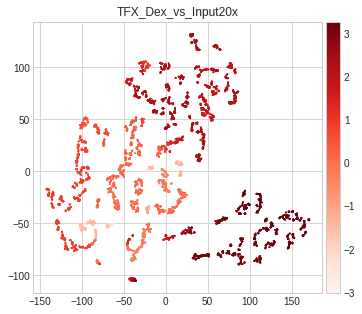

In [25]:
cval = dat.loc[:,"TFX_Dex_vs_Inp20x"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("TFX_Dex_vs_Input20x")
plt.show()

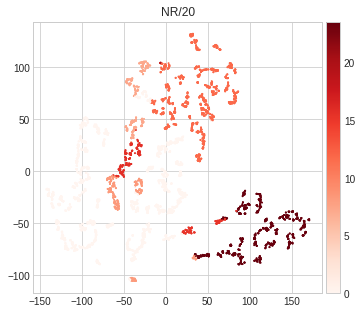

In [26]:
cval = dat.loc[:,"Mtf_NR/20"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("NR/20")
plt.show()

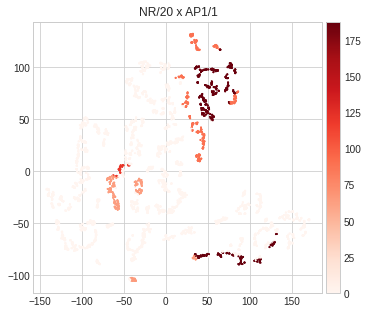

In [27]:
cval = dat.loc[:,"Mtf_NR/20"] * dat.loc[:,"Mtf_AP1/1"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=cval, cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("NR/20 x AP1/1")
plt.show()